In [162]:
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import List, Annotated, TypedDict
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_openai import ChatOpenAI

In [163]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.5)
# model = ChatOpenAI(model = "gpt-4o-mini", temperature=0.5)

## **Defining the Schemas**

In [164]:
#This class will be for the technical questions and data retrieval from Arxiv Pinecone.
class Researcher(BaseModel):
    name: str = Field(description="The name of the researcher.")
    area_of_research: str = Field(description="The area of research of the researcher.")
    field_of_study: str = Field(description="The academic or professional field the researcher specializes in.")

    @property
    def persona(self) -> str:
        return f"Researcher Name: {self.name}\nArea of Research: {self.area_of_research}\nField of Study: {self.field_of_study}\n"


#This class will be responsible for the Web search looking for how the web has reacted to the research.
class Assistant(BaseModel):
    name: str = Field(description="The name of the assistant.")
    skills: List[str] = Field(description="A list of skills the assistant possesses.")
    tasks: List[str] = Field(description="The list of tasks assigned to the assistant by their supervisor.")

    @property
    def persona(self) -> str:
        return f"Assistant Name: {self.name}\nAssistant Skills: {self.skills}\nTasks Assigned: {self.tasks}\n"


class ArxivQuery(BaseModel):
    arxiv_query: str = Field(description="The search query to retrieve research papers from Arxiv.")


class SearchQuery(BaseModel):
    search_query: str = Field(description="Search query for retrieval.")

In [165]:
class GeneratePersonas(BaseModel):
    researcher: Researcher
    assistant: Assistant


class OverallState(TypedDict):
    researcher: Researcher
    assistant: Assistant
    topic: str
    arxiv_query: str
    search_query: str # To be replaced with the results of the web search!

# **Graph**

## Generate Research & Assistant

#### Nodes

In [166]:
#Creating the Researcher and Analyst
generate_personas_prompt = """
You are tasked with generating two personas:

1. A persona for an expert researcher undergoing research in a specific topic.

2. A persona for an the assistant which assists the expert researcher by gathering non-technical, external information related to the research topic.

The topic of the research currently undergoing is: {topic}
"""


def generate_personas(state: OverallState):
    print(state["topic"])
    sys_msg = generate_personas_prompt.format(topic = state["topic"])
    llm = model.with_structured_output(GeneratePersonas)

    response = llm.invoke([SystemMessage(content = sys_msg)] + [HumanMessage(content = "Generate the researcher and their assistant.")])

    print(f"Researcher: {response.researcher}\n----------\nAssistant: {response.assistant}")

    return {
        "researcher": response.researcher,
        "assistant": response.assistant
    }

#### Researcher and VectorDB Interaction Graph

In [167]:
arxiv_query_prompt = """
You are an expert researcher given a topic for research. Your goal is to perform a literature review of the existing research related to the topic by generating a well-structured search query for retrieving relevant research papers from arxiv.

Here's your persona:
{persona}
"""

search_web_prompt = """
You are an assistant to an expert researcher. Your task is to gather extra, non-technical information about the research topic which you think might help in a better research.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the research topic.

Here's your persona:
{persona}
"""

def generate_arxiv_query(state: OverallState):
    structured_llm = model.with_structured_output(ArxivQuery)

    sys_msg = arxiv_query_prompt.format(persona = state['researcher'].persona)

    arxiv_query = structured_llm.invoke([SystemMessage(sys_msg)] + [HumanMessage(content = f"Topic of research:\n {state['topic']}")])

    print(f"Query for Arxiv: {arxiv_query.arxiv_query}\n")

    return {"arxiv_query": arxiv_query.arxiv_query}


def search_web(state: OverallState):
    system_message = search_web_prompt.format(persona = state['assistant'].persona)

    llm = model.with_structured_output(SearchQuery)
    query = llm.invoke([SystemMessage(content = system_message)] + [HumanMessage(content= f"Generate the search query for retrieval.")])

    print(query)

    return {"search_query": query.search_query}
    

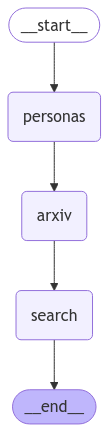

In [168]:
builder = StateGraph(OverallState)
builder.add_node("personas", generate_personas)
builder.add_node("arxiv", generate_arxiv_query)
builder.add_node("search", search_web)

builder.add_edge(START, "personas")
builder.add_edge("personas", "arxiv")
builder.add_edge("arxiv", "search")
builder.add_edge('search', END)

graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [169]:
graph.invoke({"topic": "DeepSeek AI"})

DeepSeek AI
Researcher: name='Dr. Rachel Kim' area_of_research='DeepSeek AI' field_of_study='Artificial Intelligence'
----------
Assistant: name='Alex Chen' skills=['Data Collection', 'Information Gathering', 'Research Assistance'] tasks=['Gather non-technical information on DeepSeek AI', 'Conduct market research on AI trends', 'Assist Dr. Kim with research-related tasks']
Query for Arxiv: DeepSeek AI

search_query='latest news and trends on DeepSeek AI and its applications'


{'researcher': Researcher(name='Dr. Rachel Kim', area_of_research='DeepSeek AI', field_of_study='Artificial Intelligence'),
 'assistant': Assistant(name='Alex Chen', skills=['Data Collection', 'Information Gathering', 'Research Assistance'], tasks=['Gather non-technical information on DeepSeek AI', 'Conduct market research on AI trends', 'Assist Dr. Kim with research-related tasks']),
 'topic': 'DeepSeek AI',
 'arxiv_query': 'DeepSeek AI',
 'search_query': 'latest news and trends on DeepSeek AI and its applications'}